In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from meteostat import Point, Hourly
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

np.random.seed(42)

In [50]:
# Define our study locations - diverse geographic and climatic regions
study_locations = {
    'Chicago': (41.8781, -87.6298),
    'Denver': (39.7392, -104.9903),
    'Miami': (25.7617, -80.1918),
    'Phoenix': (33.4484, -112.0740),
    'Seattle': (47.6062, -122.3321)
}

start_date = datetime(2020, 1, 1)
end_date = datetime(2024, 12, 31)

In [ ]:
def collect_weather_data(locations, start_date, end_date):
    all_data = []
    exclude_vars = ['tsun', 'snow', 'wpgt', 'prcp']
    
    for city_name, (lat, lon) in locations.items():
        try:
            point = Point(lat, lon)
            data = Hourly(point, start_date, end_date).fetch()
            
            # Get elevation from Meteostat station data
            try:
                from meteostat import Stations
                stations = Stations()
                stations = stations.nearby(lat, lon)
                station_data = stations.fetch(1)
                if not station_data.empty:
                    elevation = station_data.iloc[0]['elevation']
                else:
                    elevation = None
            except:
                elevation = None
            
            for col in exclude_vars:
                if col in data.columns:
                    data = data.drop(columns=[col])
            
            if 'coco' in data.columns:
                def group_condition_codes(code):
                    if pd.isna(code):
                        return 'Unknown'
                    code = int(code)
                    if code in [1, 2]:
                        return 'Clear'
                    elif code in [3, 4, 5, 6]:
                        return 'Cloudy/Foggy'
                    elif code in [7, 8, 9, 17]:
                        return 'Rain'
                    elif code in [10, 11, 12, 13, 14, 15, 16, 19, 21]:
                        return 'Cold Precip'
                    elif code in [18, 20, 22, 23, 24, 25, 26, 27]:
                        return 'Extreme'
                    else:
                        return 'Other'
                
                data['condition_group'] = data['coco'].apply(group_condition_codes)
            
            data['city'] = city_name
            data['latitude'] = lat
            data['longitude'] = lon
            data['elevation'] = elevation
            data['datetime'] = data.index
            data = data.reset_index()
            
            all_data.append(data)
                
        except Exception as e:
            pass
            
    if all_data:
        combined_data = pd.concat(all_data, ignore_index=True)
        
        empty_cols = []
        for col in combined_data.columns:
            if combined_data[col].isna().all():
                empty_cols.append(col)
        
        if empty_cols:
            combined_data = combined_data.drop(columns=empty_cols)
        
        return combined_data
    else:
        return pd.DataFrame()

weather_data = collect_weather_data(study_locations, start_date, end_date)

In [64]:
def prepare_wind_direction_features(df):
    df_clean = df.copy()
    
    df_clean['time'] = pd.to_datetime(df_clean['time'])
    df_clean = df_clean.sort_values(['city', 'time']).reset_index(drop=True)
    
    df_clean['hour'] = df_clean['time'].dt.hour
    df_clean['month'] = df_clean['time'].dt.month
    numerical_features = ['temp', 'dwpt', 'rhum', 'pres', 'wspd', 'hour', 'month', 'latitude', 'longitude', 'elevation']
    categorical_features = ['condition_group', 'city']
    
    available_numerical = [col for col in numerical_features if col in df_clean.columns]
    available_categorical = [col for col in categorical_features if col in df_clean.columns]
    
    for col in available_numerical:
        if df_clean[col].isnull().any():
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    for col in available_categorical:
        if df_clean[col].isnull().any():
            mode_val = df_clean[col].mode()[0] if len(df_clean[col].mode()) > 0 else 'Unknown'
            df_clean[col].fillna(mode_val, inplace=True)
    
    return df_clean, available_numerical, available_categorical

weather_clean, numerical_cols, categorical_cols = prepare_wind_direction_features(weather_data)

In [ ]:
def prepare_wind_direction_model(df):
    """
    Prepare data for circular wind direction prediction
    """
    
    model_data = df[df['wdir'].notna()].copy()
    
    numerical_features = ['temp', 'dwpt', 'rhum', 'pres', 'wspd', 'hour', 'month', 'latitude', 'longitude', 'elevation']
    numerical_available = [col for col in numerical_features if col in model_data.columns]
    
    categorical_features = ['condition_group', 'city']
    categorical_available = [col for col in categorical_features if col in model_data.columns]
    
    # Prepare features
    X_numerical = model_data[numerical_available].copy()
    X_categorical = model_data[categorical_available].copy()
    
    # Fill missing values
    X_numerical.fillna(X_numerical.median(), inplace=True)
    X_categorical.fillna(X_categorical.mode().iloc[0], inplace=True)
    
    # Convert wind direction to circular components
    wind_radians = np.radians(model_data['wdir'])
    y_sin = np.sin(wind_radians)
    y_cos = np.cos(wind_radians)
    
X_numerical, X_categorical, y_sin, y_cos, numerical_cols, categorical_cols = prepare_wind_direction_model(weather_clean)

X_numerical, X_categorical, y, numerical_cols, categorical_cols = prepare_wind_direction_model(weather_clean)

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

# Encode categorical features
label_encoders = {}
X_categorical_encoded = X_categorical.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_categorical_encoded[col] = le.fit_transform(X_categorical[col])
    label_encoders[col] = le

X = pd.concat([X_numerical, X_categorical_encoded], axis=1)

# Split data for both sine and cosine components
X_train, X_test, y_sin_train, y_sin_test = train_test_split(X, y_sin, test_size=0.2, random_state=42)
_, _, y_cos_train, y_cos_test = train_test_split(X, y_cos, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Linear Regression models for sine and cosine
linear_sin = LinearRegression()
linear_cos = LinearRegression()
linear_sin.fit(X_train_scaled, y_sin_train)
linear_cos.fit(X_train_scaled, y_cos_train)

y_sin_pred_linear = linear_sin.predict(X_test_scaled)
y_cos_pred_linear = linear_cos.predict(X_test_scaled)

# Train HistGradientBoosting models for sine and cosine
hist_sin = HistGradientBoostingRegressor(random_state=42)
hist_cos = HistGradientBoostingRegressor(random_state=42)
hist_sin.fit(X_train, y_sin_train)
hist_cos.fit(X_train, y_cos_train)

y_sin_pred_hist = hist_sin.predict(X_test)
y_cos_pred_hist = hist_cos.predict(X_test)

# Convert back to degrees
def circular_to_degrees(sin_pred, cos_pred):
    return np.degrees(np.arctan2(sin_pred, cos_pred)) % 360

y_pred_linear = circular_to_degrees(y_sin_pred_linear, y_cos_pred_linear)
y_pred_hist = circular_to_degrees(y_sin_pred_hist, y_cos_pred_hist)

# Convert test data back to degrees for comparison
y_test_degrees = np.degrees(np.arctan2(y_sin_test, y_cos_test)) % 360

# Calculate circular R² scores
def circular_r2(actual_degrees, predicted_degrees):
    # Convert to circular errors
    errors = np.abs(actual_degrees - predicted_degrees)
    circular_errors = np.minimum(errors, 360 - errors)
    
    # Calculate total sum of squares (circular)
    mean_direction = np.degrees(np.arctan2(np.mean(np.sin(np.radians(actual_degrees))), 
                                          np.mean(np.cos(np.radians(actual_degrees))))) % 360
    mean_errors = np.abs(actual_degrees - mean_direction)
    mean_circular_errors = np.minimum(mean_errors, 360 - mean_errors)
    
    ss_tot = np.sum(mean_circular_errors**2)
    ss_res = np.sum(circular_errors**2)
    
    return 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

linear_r2 = circular_r2(y_test_degrees, y_pred_linear)
hist_r2 = circular_r2(y_test_degrees, y_pred_hist)

# Select best model
if hist_r2 > linear_r2:
    best_model_name = "HistGradientBoosting"
    best_predictions = y_pred_hist
    best_r2 = hist_r2
else:
    best_model_name = "Linear Regression"
    best_predictions = y_pred_linear
    best_r2 = linear_r2
    best_rmse = linear_rmse

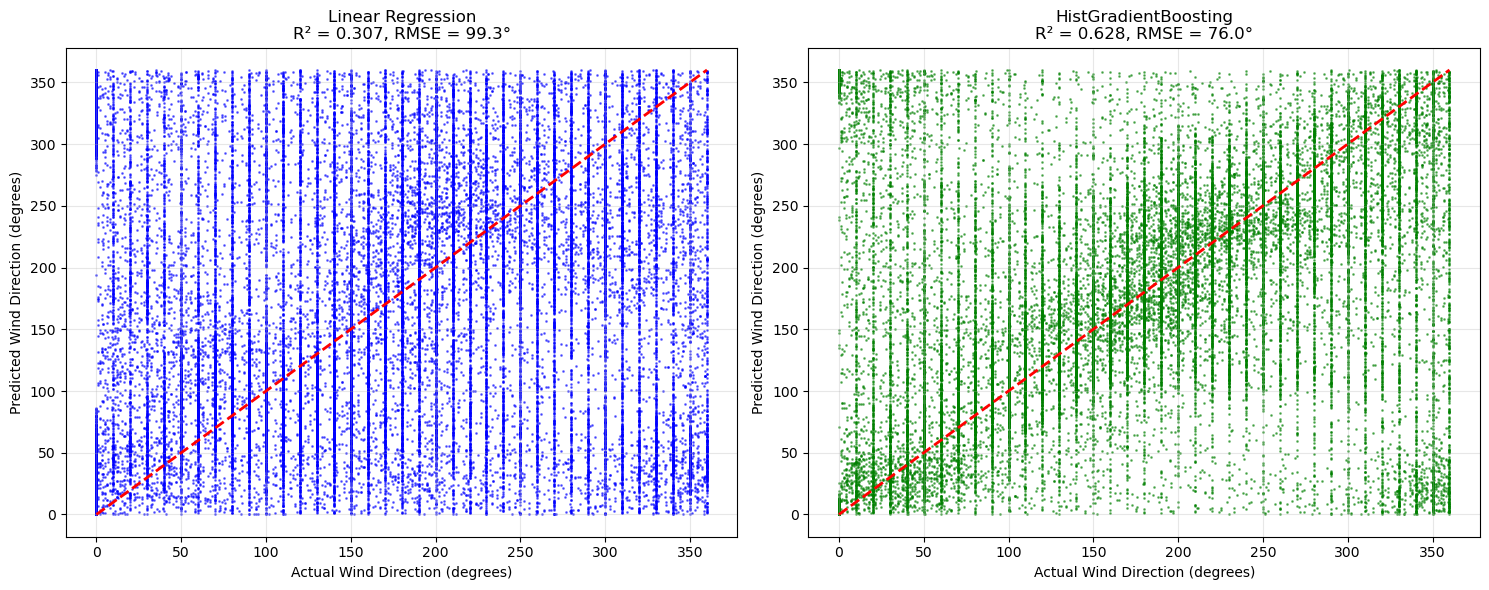

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Linear Regression plot
ax1.scatter(y_test, y_pred_linear, alpha=0.5, s=1, color='blue')
ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax1.set_xlabel('Actual Wind Direction (degrees)')
ax1.set_ylabel('Predicted Wind Direction (degrees)')
ax1.set_title(f'Linear Regression\nR² = {linear_r2:.3f}, RMSE = {linear_rmse:.1f}°')
ax1.grid(True, alpha=0.3)

# HistGradientBoosting plot
ax2.scatter(y_test, y_pred_hist, alpha=0.5, s=1, color='green')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
ax2.set_xlabel('Actual Wind Direction (degrees)')
ax2.set_ylabel('Predicted Wind Direction (degrees)')
ax2.set_title(f'HistGradientBoosting\nR² = {hist_r2:.3f}, RMSE = {hist_rmse:.1f}°')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [67]:
def circular_error(actual_degrees, predicted_degrees):
    diff = np.abs(actual_degrees - predicted_degrees)
    circular_diff = np.minimum(diff, 360 - diff)
    return circular_diff

circular_errors = circular_error(y_test_degrees, best_predictions)
circular_mae = np.mean(circular_errors)
circular_rmse = np.sqrt(np.mean(circular_errors**2))